# 폐렴 구별법

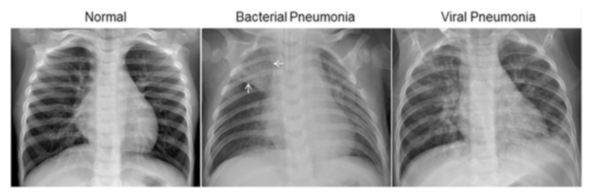

# 1. Set up

In [1]:
import os
import re
import random
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [11]:
#데이터 로드할 때 빠르게 로드할 수 있도록 하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
#X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180,180]

TRAIN_PATH = os.getenv('HOME')+'/aiffel/chest_xray/data/train/*/*'
VAL_PATH = os.getenv('HOME')+'/aiffel/chest_xray/data/val/*/*'
TEST_PATH = os.getenv('HOME')+'/aiffel/chest_xray/data/test/*/*'

#Hyperparameters
BATCH_SIZE = 16
EPOCHS = 25

# 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


- val 갯수가 너무 없으므로 train 에서 val에 쓰일 데이터를 가져온다.
1. train 데이터와 validation 데이터를 모두 filenames에 담는다.
2. 모아진 filenames를 8:2로 나눈다.

In [4]:
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


- train 데이터 내에 정상 이미지 수와 폐렴 이미지 수를 확인해보자

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0447-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person614_bacteria_2483.jpeg


- 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지 수를 확인할 수 있고, PNEUMONIA 가 있는지 확인하면 폐렴 이미지 수를 확인할 수도 있다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if 'NORMAL' in filename])
print(f"Normal images count in training set : {COUNT_NORMAL}")

COUNT_PNEUMONIA = len([filename for filename in train_filenames if 'PNEUMONIA' in filename])
print(f"Pneumonia images count in training set : {COUNT_PNEUMONIA}")

Normal images count in training set : 1070
Pneumonia images count in training set : 3115


- tf.data 인스턴스를 만들자. tensorflow에서 학습시킬 때 mini batch로 작업할 수 있도록 도와준다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [25]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


- 현재 이미지에는 라벨 데이터가 따로 없으므로 파일 경로에 'NORMAL' 이나 'PNEUMONIA'를이용해서 라벨 데이터를 만들어주자

In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == 'PNEUMONIA'   #폐렴이면 True, 정상이면 False

- 이미지 데이터의 사이즈가 제각각일 가능성이 높으므로 통일시킨 후, GPU 메모리를 더욱 효율적으로 사용하기 위해 사이즈를 줄여보자

In [9]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img

def process_path(file_path):
    label = get_label(file_path)  #라벨 검출
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

- train / validation 데이터셋 만들기

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


- 이미지 사이즈도 잘 변환되었고, 라벨도 잘 들어간 것을 확인할 수 있다.

- test 데이터셋 만들기

In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [18]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

- 위에서 하이퍼파라미터로 정의한 BATCH_SIZE 만큼 추출해보자

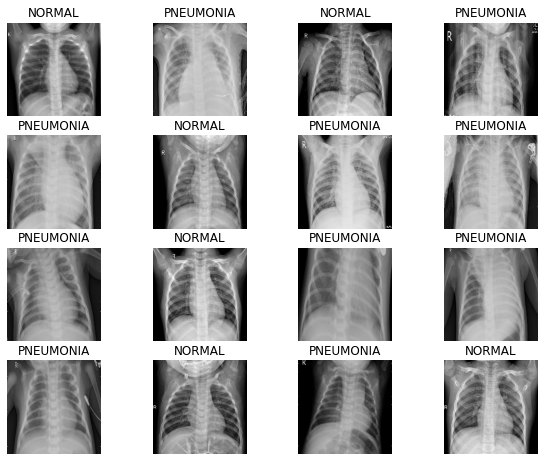

In [19]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

In [30]:
# Convolution 블럭 생성
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

# Dense 블럭 생성
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [31]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation= 'sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

위에서 'Normal' 과 'Pneumonia' 중에 'Pneumonia'데이터가 훨씬 더 많은 것을 확인했다. 이렇게 한 라벨이 너무 많은 경우를 imbalance 하다고 하는데, 데이터를 학습할 때 imbalance한 데이터의 경우 학습효과가 좋지 않을 수 있다.   
   
   
이런 문제들을 해결하는 방법으로 Weight balancing 이라는 테크닉이 사용된다. 이는 training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법이다.   

In [26]:
#weight_for_0 는 'Normal' 이미지에 사용할 weight
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
#weight_for_1 는 'Pneumonia' 이미지에 사용할 weight
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0 : weight_for_0, 1 : weight_for_1}

print('Weight for Normal : {:.2f}'.format(weight_for_0))
print('Weight for Pneumonia : {:.2f}'.format(weight_for_1))

Weight for Normal : 1.96
Weight for Pneumonia : 0.67


# 6. 모델 훈련

- 이미지의 라벨이 두 개 밖에 없기 때문에 'binary_cross entopy' loss 를 사용하자.

In [32]:
with tf.device('/GPU:0'):
    model = build_model()
    
    METRICS = ['accuracy',
               tf.keras.metrics.Precision(name='precision'),
               tf.keras.metrics.Recall(name='recall')
              ]
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

In [34]:
with tf.device('/GPU:0'):
    history = model.fit(train_ds,
                       steps_per_epoch = TRAIN_IMG_COUNT // BATCH_SIZE,
                       epochs = EPOCHS,
                       validation_data = val_ds,
                       validation_steps = VAL_IMG_COUNT // BATCH_SIZE,
                       class_weight = class_weight
                       )

Epoch 1/25
261/261 [==============================] - 84s 227ms/step - loss: 0.5646 - accuracy: 0.6977 - precision: 0.9237 - recall: 0.6454 - val_loss: 0.5786 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 58s 222ms/step - loss: 0.2230 - accuracy: 0.9088 - precision: 0.9790 - recall: 0.8982 - val_loss: 1.0206 - val_accuracy: 0.7327 - val_precision: 0.7327 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 57s 221ms/step - loss: 0.1898 - accuracy: 0.9315 - precision: 0.9829 - recall: 0.9239 - val_loss: 0.1077 - val_accuracy: 0.9587 - val_precision: 0.9523 - val_recall: 0.9934
Epoch 4/25
261/261 [==============================] - 59s 228ms/step - loss: 0.1740 - accuracy: 0.9319 - precision: 0.9787 - recall: 0.9287 - val_loss: 0.0887 - val_accuracy: 0.9712 - val_precision: 0.9919 - val_recall: 0.9685
Epoch 5/25
261/261 [==============================] - 61s 233ms/step - loss: 0.1553 - accura

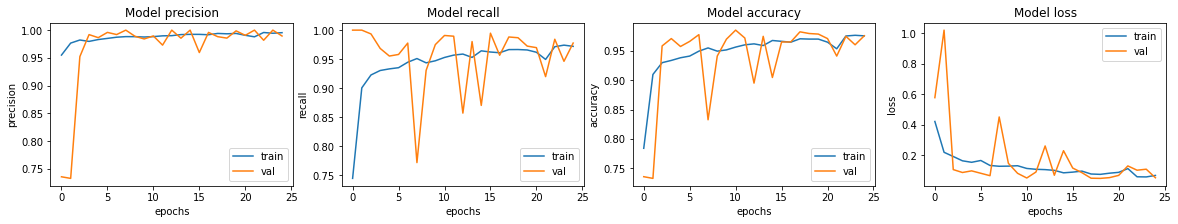

In [35]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [37]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 6s 138ms/step - loss: 1.1723 - accuracy: 0.8189 - precision: 0.7809 - recall: 0.9872
Loss: 1.1723414659500122,
Accuracy: 0.8189102411270142,
Precision: 0.7809330821037292,
Recall: 0.9871794581413269
